# TP1 vision par ordinateur

## Importation des données et tests

In [1]:
%cd ~/Documents/INF6804/TP/TP1
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
import re

data_root = "./dataset"
results_root = "./results"
dataset_categories = os.listdir(data_root)
dict_video = {}
for folder in dataset_categories:
    dict_video[folder] = os.listdir(data_root + "/" + folder)

/home/gregoire/Documents/INF6804/TP/TP1


## Flot optique

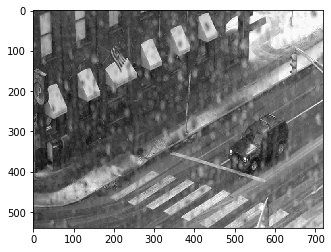

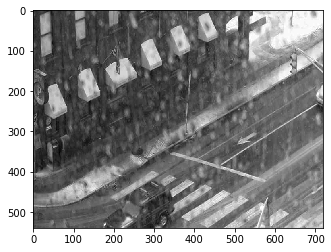

In [2]:
path = data_root + "/" + 'badWeather' + "/" + dict_video['badWeather'][0] + "/" + "input" + "/"

image1 = cv2.imread(path + 'in000100.jpg',cv2.IMREAD_GRAYSCALE)
plt.imshow(image1, cmap = plt.get_cmap('gray'))
plt.show()
image2 = cv2.imread(path + 'in000200.jpg',cv2.IMREAD_GRAYSCALE)
plt.imshow(image2, cmap = plt.get_cmap('gray'))
plt.show()

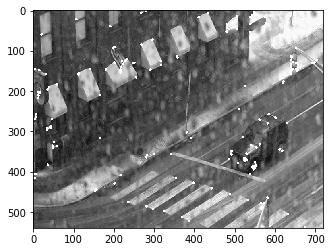

In [3]:
# Extraction de coins. On calculera le flux optique pour les coins.
corners1 = cv2.goodFeaturesToTrack(image1, maxCorners = 2000, qualityLevel = 0.1, minDistance = 3, blockSize = 5 )

temp = np.int32(corners1)
img = np.copy(image1)
for i in range(0, len(corners1)):
    cv2.circle(img,(temp[i,0,0],temp[i,0,1]),3,255,-1)

plt.imshow(img, cmap = plt.get_cmap('gray'))
plt.show()

In [4]:
corners2, st, err = cv2.calcOpticalFlowPyrLK(image1, image2, corners1, None, winSize  = (15,15), maxLevel = 0, 
                                       criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))


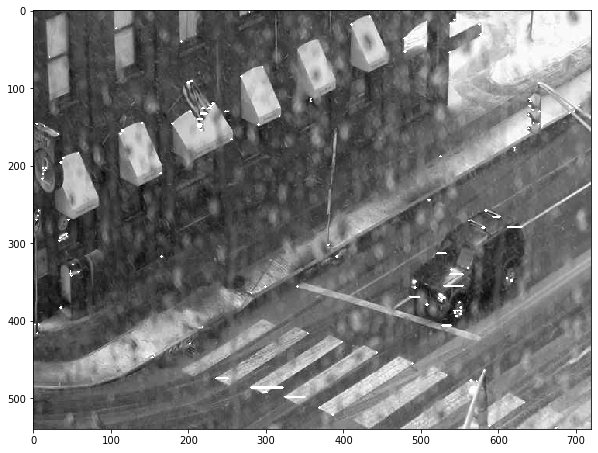

In [5]:
fig1 = plt.figure(figsize = (10,10))
temp1 = np.int32(corners1)
temp2 = np.int32(corners2)
img = np.copy(image1)
for i in range(0, len(corners1)):
    cv2.line(img, (temp1[i,0,0],temp1[i,0,1]),(temp2[i,0,0],temp1[i,0,1]), 255, 2)
plt.imshow(img, cmap = plt.get_cmap('gray'))
plt.show()

In [6]:
# On calcule le flux optique. On obtiendra une valeur de Vx, Vy pour chaque pixel
flot = cv2.calcOpticalFlowFarneback(image1,image2, None, 0.5, 3, 15, 3, 5, 1.2, 0)
print("forme du flot: " + str(flot.shape))

forme du flot: (540, 720, 2)


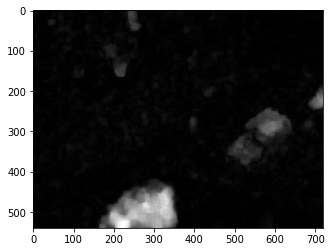

In [7]:
# on recupère la nomre du vecteur V, composé de Vx et Vy,
# en passant en coordonnées polaires
mag, _ = cv2.cartToPolar(flot[...,0], flot[...,1])
# on peut reconstruire notre image en nuance de gris
img = np.uint8(cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX))
plt.imshow(img, cmap = plt.get_cmap('gray'))
plt.show()

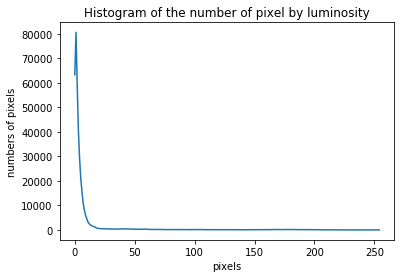

In [8]:
# On essaye de supprimer les pixels presques noirs
histogram = np.bincount(img.flatten())
plt.plot(range(0,255), histogram)
plt.xlabel('pixels')
plt.ylabel('numbers of pixels')
plt.title('Histogram of the number of pixel by luminosity')
plt.show()

On peut voir qu'on peut essayer de supprimer les pixels dont la valeur est inférieur à 40 sans trop prendre de risque.

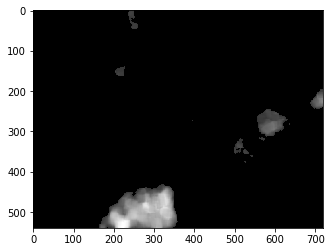

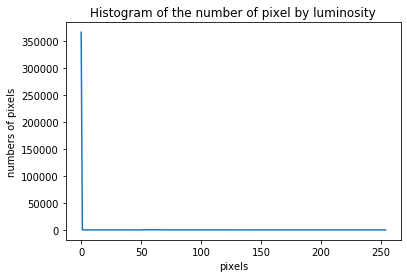

In [9]:
seuil=50

for index, pix in np.ndenumerate(img):
    img[index] = pix if pix > seuil else 0
plt.imshow(img, cmap = plt.get_cmap('gray'))
plt.show()
histogram = np.bincount(img.flatten())
plt.plot(range(0,255), histogram)
plt.xlabel('pixels')
plt.ylabel('numbers of pixels')
plt.title('Histogram of the number of pixel by luminosity')
plt.show()

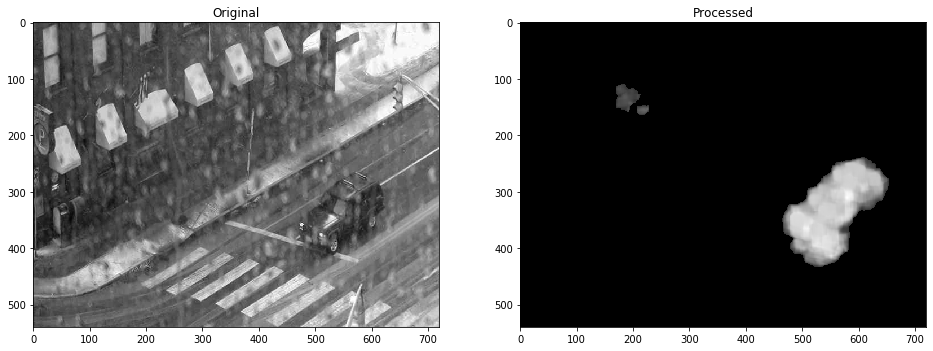

In [10]:
def flot_optique(img1, img2, seuil, print_img=True):
    image1 = cv2.imread(img1,cv2.IMREAD_GRAYSCALE)
    image2 = cv2.imread(img2,cv2.IMREAD_GRAYSCALE)
    # On calcule le flux optique. Cela nous donnera une valeur de Vx, Vy pour chaque pixel
    flot = cv2.calcOpticalFlowFarneback(image1,image2, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    mag, _ = cv2.cartToPolar(flot[...,0], flot[...,1])
    # on peut reconstruire notre image en nuance de gris
    img = np.uint8(cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX))
    for index, pix in np.ndenumerate(img):
        img[index] = pix if pix > seuil else 0
    if print_img:
        fig = plt.figure(figsize=(16,16))
        original = fig.add_subplot(1,2,1)
        original_plot = plt.imshow(image2, cmap = plt.get_cmap('gray'))
        original.set_title('Original')

        processed = fig.add_subplot(1,2,2)
        processed_plot = plt.imshow(img, cmap = plt.get_cmap('gray'))
        processed.set_title('Processed')
        plt.show()
    return img

img = flot_optique(path + 'in000100.jpg', path + 'in000120.jpg', seuil)

### Validation par matrice de confusion

On réalise l'intersection entre les pixels non noir de l'image du flot optique et les pixels non noir du groundthruth

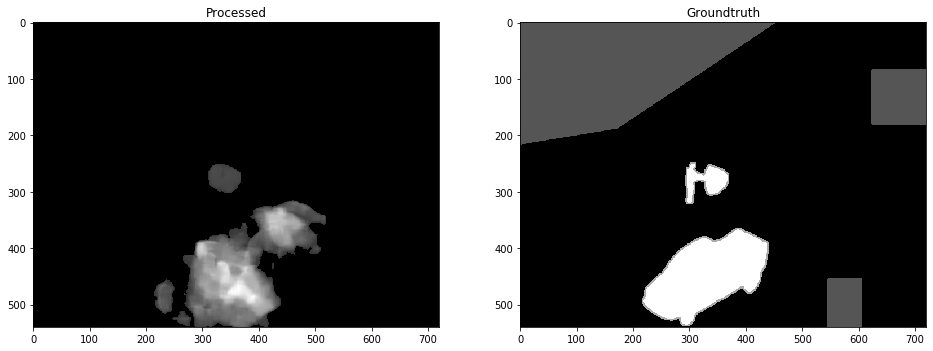

In [11]:
img = flot_optique(path + 'in000500.jpg', path + 'in000510.jpg', seuil, False)
path_gt = data_root + "/" + 'badWeather' + "/" + dict_video['badWeather'][0] + "/" + "groundtruth" + "/"

grd_truth = cv2.imread(path_gt + 'gt000510.png',cv2.IMREAD_GRAYSCALE)

fig = plt.figure(figsize=(16,16))
processed = fig.add_subplot(1,2,1)
processed_plot = plt.imshow(img, cmap = plt.get_cmap('gray'))
processed.set_title('Processed')

gt = fig.add_subplot(1,2,2)
gt_plot = plt.imshow(grd_truth, cmap = plt.get_cmap('gray'))
gt.set_title('Groundtruth')

plt.show()

              numbers purcentage  gray scale
True positif    19033          4       white
False positif   17050          4  light gray
True negative  348404         89   dark gray
False negatif    4313          1       black

Accuracy: 0.945054012345679
Precision: 0.5274783138874262
Recall: 0.8152574316799451


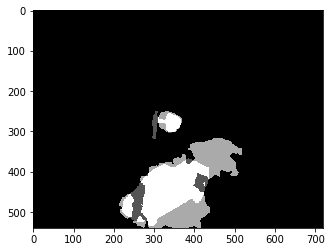

In [12]:
img_merge = np.zeros((img.shape[0], img.shape[1]), dtype='int32')

TP = 0
FP = 0
TN = 0
FN = 0

for index,_ in np.ndenumerate(img_merge):
    if img[index] > 0:
        if grd_truth[index] > 170:
            img_merge[index] = 255
            TP += 1
        else:
            img_merge[index] = 170
            FP += 1
    else:
        if grd_truth[index] > 170:
            img_merge[index] = 85
            FN += 1
        else:
            img_merge[index] = 0
            TN += 1
            
tot = TP+FP+TN+FN
print(pd.DataFrame(
    np.array(
        [[TP, int(TP * 100 /tot), 'white'],
         [FP, int(FP * 100 /tot), 'light gray'],
         [TN, int(TN * 100 /tot), 'dark gray'],
         [FN, int(FN * 100 /tot), 'black']]),
    index=['True positif', 'False positif', 'True negative', 'False negatif'],
    columns=['numbers', 'purcentage', 'gray scale']))

print("\nAccuracy: " + str((TP + TN) / (tot)))
print("Precision: " + str(TP / (TP + FP)))
print("Recall: " + str(TP / (TP + FN)))

plt.imshow(img_merge, cmap = plt.get_cmap('gray'))
plt.show()

On definie une fonction pour des questions de reusabilitée

In [25]:
def test_image(original, img, grd_truth):  
    img_merge = np.zeros((img.shape[0], img.shape[1]), dtype='int32')

    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for index,_ in np.ndenumerate(img_merge):
        if img[index] > 0:
            if grd_truth[index] > 170:
                img_merge[index] = 255
                TP += 1
            else:
                img_merge[index] = 170
                FP += 1
        else:
            if grd_truth[index] > 170:
                img_merge[index] = 85
                FN += 1
            else:
                img_merge[index] = 0
                TN += 1

    tot = TP+FP+TN+FN
    print(pd.DataFrame(
        np.array(
            [[TP, int(TP * 100 /tot), 'white'],
             [FP, int(FP * 100 /tot), 'light gray'],
             [TN, int(TN * 100 /tot), 'dark gray'],
             [FN, int(FN * 100 /tot), 'black']]),
        index=['True positif', 'False positif', 'True negative', 'False negatif'],
        columns=['numbers', 'purcentage', 'gray scale']))

    print("\nAccuracy: " + str((TP + TN) / (tot)))
    print("Precision: " + str(TP / (TP + FP)))
    print("Recall: " + str(TP / (TP + FN)))
   
    fig = plt.figure(figsize=(16,16))
    
    original_fig = fig.add_subplot(2,2,1)
    original_plot = plt.imshow(original, cmap = plt.get_cmap('gray'))
    original_fig.set_title('original')
    
    gt = fig.add_subplot(2,2,2)
    gt_plot = plt.imshow(grd_truth, cmap = plt.get_cmap('gray'))
    gt.set_title('Groundtruth')
    
    processed = fig.add_subplot(2,2,3)
    processed_plot = plt.imshow(img, cmap = plt.get_cmap('gray'))
    processed.set_title('Processed')

    valid = fig.add_subplot(2,2,4)
    valid_plot = plt.imshow(img_merge, cmap = plt.get_cmap('gray'))
    valid.set_title('validation')
    plt.show()

## Segmentation

### Utilisation de Yolo

In [14]:
#!git clone https://github.com/AlexeyAB/darknet.git
%cd darknet
#!make
#!wget https://pjreddie.com/media/files/yolov3.weights

/home/gregoire/Documents/INF6804/TP/TP1/darknet


In [21]:
!./darknet detector test ./cfg/coco.data ./cfg/yolov3.cfg ./yolov3.weights -ext_output ../dataset/badWeather/wetSnow/input/in000510.jpg > ../results.txt

 OpenCV isn't used 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,  wt = 0, wn = 0, outputs: 104 x 104 x 128 0.001 BF
   9 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
  10 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
  11 Shortcut Layer: 8,  wt = 0, wn = 0, o

Loading weights from ./yolov3.weights...Done! Loaded 107 layers from weights-file 
Not compiled with OpenCV, saving to predictions.png instead


              numbers purcentage  gray scale
True positif    21682          5       white
False positif   25482          6  light gray
True negative  339972         87   dark gray
False negatif    1664          0       black

Accuracy: 0.9301800411522634
Precision: 0.45971503689254517
Recall: 0.9287244067506211


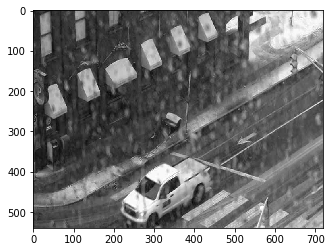

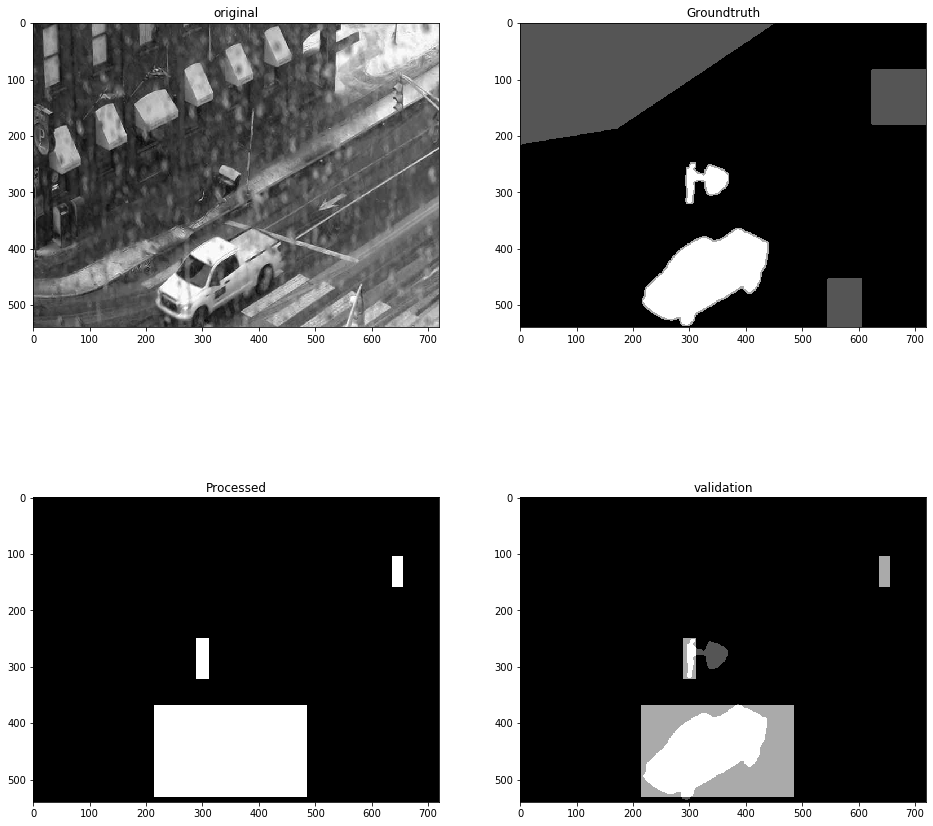

In [26]:
img = np.zeros((img.shape[0], img.shape[1]), dtype='int32')
with open("../results.txt", 'r') as result:
    for line in result:
        square = re.search('(left_x:.*height:  .*)', line)
        if square:

            left_x = int(re.search("left_x:[\s]*(\d*?)[\s]*top_y", square.string).group(1))
            top_y = int(re.search("top_y:[\s]*(\d*?)[\s]*width:", square.string).group(1))
            width = int(re.search("width:[\s]*(\d*?)[\s]*height:", square.string).group(1))
            height = int(re.search("height:[\s]*(\d*?)[\s]*\)", square.string).group(1))
            img[top_y: top_y + height, left_x:left_x + width] = 255
            
path_gt = "../dataset/badWeather/wetSnow/groundtruth/"
grd_truth = cv2.imread(path_gt + 'gt000510.png',cv2.IMREAD_GRAYSCALE)
original = cv2.imread('../dataset/badWeather/wetSnow/input/in000510.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(original, cmap = plt.get_cmap('gray'))
test_image(original, img, grd_truth)